# Commit to Deploy Time

###  Draft RPGF3 List ✨
**NOTE: Highly experimental and not all contract data is currently available in this version.**

In [1]:
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "CommitToDeployTime"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-05_CommitToDeployTime.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list calculates the amount of time between a project's first commit to a GitHub repo",
                "and its first contract event on OP Mainnet, measured in days. It also looks at the number",
                "of total transactions a project has generated on OP Mainnet. Finally, it computes a score",
                "from the square root of the ratio of total transactions to day to commit time.",
                "The list awards OP Tokens pro-rata to projects based on scores. Projects with a low commit to",
                "deploy time and a high transaction volume on OP Mainnet before best on this metric."
            ])
LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            'DEVELOPER_ECOSYSTEM', 
            'END_USER_EXPERIENCE_AND_ADOPTION', 
            'OP_STACK'
            ]

AWARD_AMT = 1 * 10e6

JSON_PATH = DATA_DIR + "lists/" + LIST_NAME + ".json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
#duplicates = oso.check_duplicate_slugs()

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)

query = f"""
    SELECT
        p."slug" AS slug,
        MIN(CASE WHEN e."typeId" IN (2,4) THEN e."time" END) AS first_commit,
        MIN(CASE WHEN e."typeId" = 25 THEN e."time" END) AS first_txn,
        SUM(CASE WHEN e."typeId" = 25 THEN e."amount" END) AS count_txn
    FROM event e
    JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    JOIN project p ON paa."projectId" = p.id        
    WHERE
        e."typeId" IN (2,4,25)
        AND p.slug IN ('{slugs_list}')
    GROUP BY p."slug";

"""
results = execute_query(query, col_names=True)

In [5]:
# transform query results

df = (
    pd.DataFrame(results[1:], columns=results[0])
    .dropna()
    .set_index('slug')
)
df['commit_to_deploy'] = df.apply(lambda x: (x['first_txn'] - x['first_commit']).days, axis=1)
df['score'] = (df['count_txn'] / df['commit_to_deploy']) ** .5
df.head()

,first_commit,first_txn,count_txn,commit_to_deploy,score
slug,,,,,
0x-splits,2022-01-04 19:43:52+00:00,2022-10-05 00:00:00+00:00,347.0,273,1.127414
1w3,2022-12-26 17:54:35+00:00,2023-07-07 00:00:00+00:00,5.0,192,0.161374
across,2021-08-20 20:06:28+00:00,2021-11-23 00:00:00+00:00,331800.0,94,59.412013
acrypto-s,2019-11-10 15:55:54+00:00,2023-01-27 00:00:00+00:00,56.0,1173,0.218497
another-world,2022-11-21 21:25:32+00:00,2023-05-05 00:00:00+00:00,933.0,164,2.385168


# Generate the list

In [6]:
named_list = listify(df['score'].to_dict(), AWARD_AMT)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

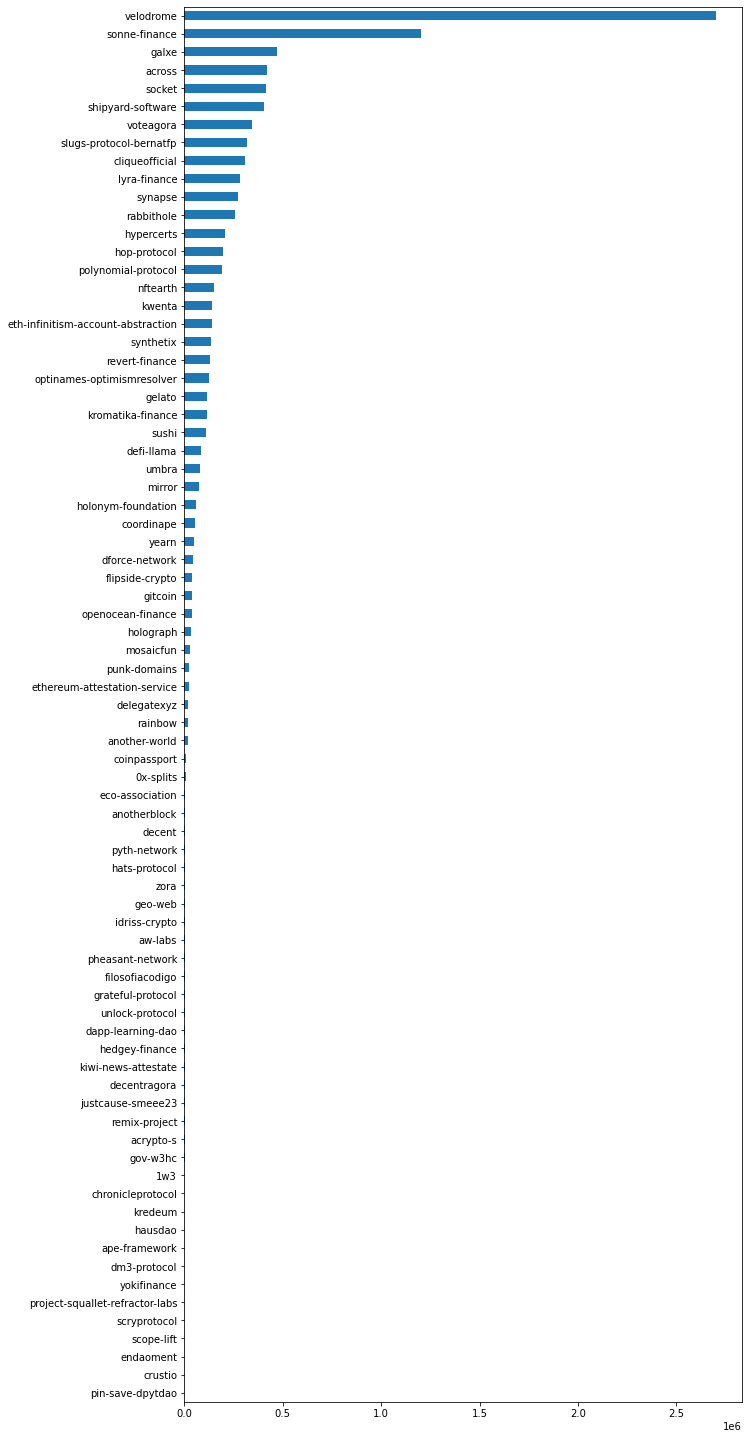

In [7]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [8]:
eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, LIST_CATS)

In [9]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)